<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, Bidirectional, MaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-04-11 20:56:54--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-04-11 20:56:54--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-04-11 20:56:55--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['prince.txt',
 'johnny-cash.txt',
 'lin-manuel-miranda.txt',
 'missy-elliott.txt',
 'bruce-springsteen.txt',
 'lorde.txt',
 'drake.txt',
 'michael-jackson.txt',
 'dolly-parton.txt',
 'jimi-hendrix.txt',
 'britney-spears.txt',
 'bieber.txt',
 'bjork.txt',
 'dr-seuss.txt',
 'disney.txt',
 'Lil_Wayne.txt',
 'eminem.txt',
 'al-green.txt',
 'alicia-keys.txt',
 'blink-182.txt',
 'notorious_big.txt',
 'janisjoplin.txt',
 'amy-winehouse.txt',
 'beatles.txt',
 'radiohead.txt',
 'notorious-big.txt',
 'joni-mitchell.txt',
 'Kanye_West.txt',
 'bruno-mars.txt',
 'kanye.txt',
 'nicki-minaj.txt',
 'leonard-cohen.txt',
 'bob-dylan.txt',
 'patti-smith.txt',
 'nickelback.txt',
 'nirvana.txt',
 'lil-wayne.txt',
 'adele.txt',
 'cake.txt',
 'bob-marley.txt',
 'paul-simon.txt',
 'nursery_rhymes.txt',
 'lady-gaga.txt',
 'r-kelly.txt',
 'kanye-west.txt',
 'ludacris.txt',
 'dj-khaled.txt',
 'rihanna.txt',
 'dickinson.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-4-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [7]:
# cada verso lo guardamos en una lista
text = list(df.loc[:,0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [8]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [9]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 29., 305., 221., 523., 293.,  72., 180.,  97.,  42.,  39.,  22.,
         12.,   4.,   3.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([ 1.  ,  2.65,  4.3 ,  5.95,  7.6 ,  9.25, 10.9 , 12.55, 14.2 ,
        15.85, 17.5 , 19.15, 20.8 , 22.45, 24.1 , 25.75, 27.4 , 29.05,
        30.7 , 32.35, 34.  ]),
 <BarContainer object of 20 artists>)

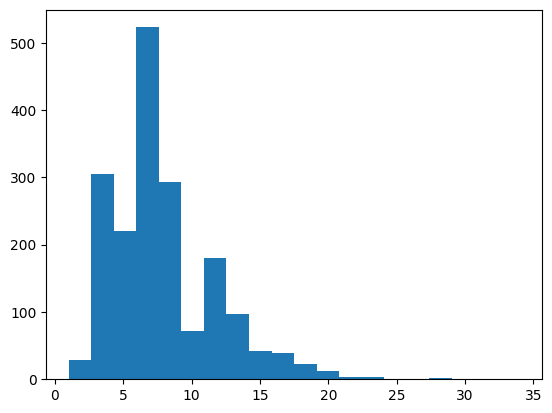

In [10]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

**Max Content Size calculado**

In [14]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


**Max Content Size menor**

In [13]:
max_context_size_2 = int(np.percentile(length_sentences, 75)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size_2}')

max_context_size: 9


###  Tokenizar

In [15]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [16]:
tokenized_sentences

[[200, 10, 12, 907, 908, 42, 909, 121],
 [22, 13, 638, 91, 217, 349, 79, 4, 314],
 [23, 2, 160, 9, 200, 520, 35, 83, 910, 3, 78, 2, 911, 4, 15],
 [173, 7, 912, 913, 397, 8],
 [23, 200, 218, 520, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200],
 [175,
  175,
  175,
  175,
  175,
  175,
  175,
  36,
  2,
  230,
  522,
  9,
  398,
  17,
  914,
  639,
  640,
  133,
  4,
  8],
 [447, 162, 17, 315, 29, 13, 15],
 [5, 9, 12, 915, 17, 916, 19, 20, 189, 74, 9, 917, 17, 8],
 [447, 162, 17, 315, 29, 13, 15],
 [29, 13, 15, 29, 13, 15, 29, 13, 15, 29, 13, 15],
 [448, 162, 17, 315, 29, 13, 15, 5, 36, 3, 399, 918, 107, 3

In [17]:
max_context_size+1

13

In [18]:
max_context_size_2+1

10

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [19]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

**Token Sentences original**

In [20]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [21]:
len(tok_sent)

1957

**Token Sentences Nuevo size**

In [22]:
# Generamos las sentencias con este nuevo contexto
tok_sent_2 = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size_2+1):
    extra = len(sent)-(max_context_size_2+1) + 1
    for i in range(extra):
      tok_sent_2.append(sent[i:i+max_context_size_2+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent_2.append(sent)

In [23]:
len(tok_sent_2)

2718

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

**Con data augmentation ambos token sentences**

In [24]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [25]:
# Realizamos el augmentation
tok_sent_augm_2 = []

for sent in tok_sent_2:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm_2.append(pad_sequences(subseq, maxlen=max_context_size_2+1, padding='pre'))

**Concatenamos las secuencias**

In [26]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [27]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs_2 = np.concatenate(tok_sent_augm_2, axis=0)

In [28]:
train_seqs.shape

(15325, 13)

In [29]:
train_seqs_2.shape

(19970, 10)

In [30]:
# Realizamos un chequeo de dimensiones
train_seqs_2[:10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   5, 217],
       [  0,   0,   0,   0,   0,   0,   0,   5, 217,  19],
       [  0,   0,   0,   0,   0,   0,   5, 217,  19, 384],
       [  0,   0,   0,   0,   0,   5, 217,  19, 384,   2],
       [  0,   0,   0,   0,   5, 217,  19, 384,   2, 432],
       [  0,   0,   0,   5, 217,  19, 384,   2, 432,   3],
       [  0,   0,   5, 217,  19, 384,   2, 432,   3, 257],
       [  0,   0,   0,   0,   0,   0,   0,   0, 248,  12],
       [  0,   0,   0,   0,   0,   0,   0, 248,  12, 375],
       [  0,   0,   0,   0,   0,   0, 248,  12, 375, 376]], dtype=int32)

**Generamos ambos sets de datos**

In [31]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [32]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X2 = train_seqs_2[:,:-1]
y2 = train_seqs_2[:,-1]

In [33]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [34]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [35]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [36]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'yesterday': 10, 'so': 61, 'seemed': 1, 'all': 177, 'my': 134, 'away': 21, 'far': 1, 'troubles': 1, 'looks': 2, 'here': 33, 'to': 307, 'though': 11, 'stay': 7, 'now': 90, "they're": 5, 'it': 125, 'as': 25, 'half': 1, "i'm": 66, 'oh': 77, 'be': 108, 'i': 400, 'used': 1, 'man': 34, 'in': 186, 'suddenly': 3, 'believe': 15, 'not': 32, 'the': 376, 'shadow': 1, 'hanging': 1, "there's": 14, 'me': 219, 'over': 5, 'a': 270, 'came': 11, 'say': 76, "wouldn't": 4, 'why': 20, "don't": 74, 'she': 90, 'had': 19, 'go': 38, 'know': 132, 'long': 25, 'something': 13, 'was': 48, 'for': 62, 'game': 3, 'play': 10, 'an': 15, 'easy': 9, 'love': 181, 'said': 14, 'wrong': 6, 'such': 9, 'need': 51, 'hide': 13, 'place': 10, 'when': 71, 'myself': 3, 'mm': 3, 'find': 10, 'mary': 2, 'comes': 20, 'mother': 2, 'of': 109, 'times': 5, 'trouble': 1, 'speaking': 4, 'words': 14, 'wisdom': 7, 'let': 55, 'front': 1, 'standing': 13, 'is': 89, 'right': 25, 'and': 311, 'hour': 1, 'darkness': 1, 'brok


### Definir el modelo

**Modelo original**

In [37]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 5)             8145      
                                                                 
 lstm (LSTM)                 (None, 12, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1629)              53757     
                                                                 
Total params: 114926 (448.93 KB)
Trainable params: 11492

**Modelo 2: más capas convolucionales y bidireccionales**

In [38]:
# Segundo modelo
model_2 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model_2.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_2.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))

# Capas recurrentes bidireccionales (BRNN):
model_2.add(Bidirectional(LSTM(64, return_sequences=True)))
model_2.add(Dropout(0.2))

# Capa LSTM adicional:
model_2.add(Bidirectional(LSTM(64)))

# Capa densa con ReLU:
model_2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax:
# La salida vuelve al espacio de 1628 palabras posibles
model_2.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model_2.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 5)             8145      
                                                                 
 conv1d (Conv1D)             (None, 10, 32)            512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 32)             0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 5, 128)            49664     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)              

**Modelo 3: añadimos aún más capas convolucionales y bidireccionales**

In [39]:
# Realizamos un tercer modelo
model_3 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model_3.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas convolucionales:
model_3.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))

# Capas recurrentes bidireccionales (BRNN):
model_3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_3.add(Dropout(0.2))
model_3.add(Bidirectional(LSTM(128)))

# Capa densa con ReLU:
model_3.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax:
# La salida vuelve al espacio de 1628 palabras posibles
model_3.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model_3.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 12, 5)             8145      
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 32)            512       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             6208      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 128)           

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [40]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:

          # armamos todas las subsecuencias
          subseq = [seq[:i] for i in range(len(seq))]
          target = [seq[i] for i in range(len(seq))]
          bb = pad_sequences(subseq, maxlen=max_context_size, padding='pre')

          # utilizamos el modelo para que haga su predicción en cada subsecuencia
          # (son las probabilidades condicionadas)
          predictions = self.model.predict(bb,verbose=0)

          # en `probs`iremos guardando las probabilidades de los términos target
          probs = []

          for idx_seq, idx_vocab in enumerate(target):
              probs.append(predictions[idx_seq,idx_vocab])

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/len(target)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [41]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
478/479 [============================>.] - ETA: 0s - loss: 5.9917
 mean perplexity: 2211.7509153774054 

479/479 [==============================] - 45s 83ms/step - loss: 5.9907
Epoch 2/50
479/479 [==============================] - ETA: 0s - loss: 5.6623
 mean perplexity: 3532.978758492655 

479/479 [==============================] - 41s 85ms/step - loss: 5.6623
Epoch 3/50
476/479 [============================>.] - ETA: 0s - loss: 5.4756
 mean perplexity: 16434.440287067107 

479/479 [==============================] - 47s 98ms/step - loss: 5.4757
Epoch 4/50
177/479 [==========>...................] - ETA: 5s - loss: 5.2794

KeyboardInterrupt: 

- Luego de 3 épocas vemos que el valor de perplexity sube.
- Se decide cortar el entrenamiento.

In [42]:
# Entreno el segundo modelo
hist_2 = model_2.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
479/479 [==============================] - ETA: 0s - loss: 5.9639
 mean perplexity: 1451.455668328834 

479/479 [==============================] - 61s 110ms/step - loss: 5.9639
Epoch 2/50
477/479 [============================>.] - ETA: 0s - loss: 5.5918
 mean perplexity: 5702.713409936117 

479/479 [==============================] - 39s 81ms/step - loss: 5.5905
Epoch 3/50
479/479 [==============================] - ETA: 0s - loss: 5.3796
 mean perplexity: 17672.251499921756 

479/479 [==============================] - 38s 79ms/step - loss: 5.3796
Epoch 4/50
163/479 [=========>....................] - ETA: 6s - loss: 5.1890

KeyboardInterrupt: 

- Comparando con el modelo original, el perplexity sigue subiendo.
- Se decide cortar el entrenamiento.

In [43]:
# Entreno el tercer modelo
hist_3 = model_3.fit(X, y, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
477/479 [============================>.] - ETA: 0s - loss: 6.0004
 mean perplexity: 2154.548415534993 

479/479 [==============================] - 65s 78ms/step - loss: 6.0000
Epoch 2/50
477/479 [============================>.] - ETA: 0s - loss: 5.7158
 mean perplexity: 2437.479786938389 

479/479 [==============================] - 36s 76ms/step - loss: 5.7152
Epoch 3/50
476/479 [============================>.] - ETA: 0s - loss: 5.6668
 mean perplexity: 5478.08256252218 

479/479 [==============================] - 36s 75ms/step - loss: 5.6672
Epoch 4/50
168/479 [=========>....................] - ETA: 5s - loss: 5.6123

KeyboardInterrupt: 

- Con este tercer modelo, podemos ver que exite una gran mejora, pero la perplexity sigue subiendo así que no podemos resolver de la mejora manera.
- Se decide cortar el entrenamiento.

**Probamos con X2 e y2**

In [44]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X2, y2, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
622/625 [============================>.] - ETA: 0s - loss: 5.1629
 mean perplexity: 19767.268920897553 

625/625 [==============================] - 70s 66ms/step - loss: 5.1611
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 4.9851
 mean perplexity: 54769.74406464513 

625/625 [==============================] - 41s 65ms/step - loss: 4.9851
Epoch 3/50
623/625 [============================>.] - ETA: 0s - loss: 4.8613
 mean perplexity: 489060.36950228014 

625/625 [==============================] - 39s 62ms/step - loss: 4.8615
Epoch 4/50
144/625 [=====>........................] - ETA: 6s - loss: 4.7624

KeyboardInterrupt: 

In [45]:
# Entreno el segundo modelo
hist_2 = model_2.fit(X2, y2, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/50
624/625 [============================>.] - ETA: 0s - loss: 5.4280
 mean perplexity: 259825.48942084692 

625/625 [==============================] - 105s 81ms/step - loss: 5.4280
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 5.2549
 mean perplexity: 430225.3325464904 

625/625 [==============================] - 43s 68ms/step - loss: 5.2549
Epoch 3/50
624/625 [============================>.] - ETA: 0s - loss: 5.1549
 mean perplexity: 509352.4216083253 

625/625 [==============================] - 40s 64ms/step - loss: 5.1548
Epoch 4/50
447/625 [====================>.........] - ETA: 4s - loss: 5.0840

KeyboardInterrupt: 

In [ ]:
# Entreno el tercer modelo
hist_3 = model_3.fit(X2, y2, epochs=50, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

- Con este nuevo dataset (X2,y2) tenemos mejores resultados comparativos en las primeras épocas en loss pero no en perplexity.
- ¿Vale la pena plantearse usar loss en vez de perplexity?

**Graficamos los resultados**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Nuevo corpus, mayor al de canciones


### Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(fn=model_response,
                     inputs=["textbox"],
                     outputs="text")#,    layout="vertical")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://91124fb4030ff59298.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 27ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://91124fb4030ff59298.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 20ms/step


"hey jude don't help you"

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times")

1/1 [==============================] - 0s 21ms/step


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 12), found shape=(None, 3)


In [ ]:
# veamos las salidas
decode(salidas[0])

NameError: name 'salidas' is not defined

### Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.